In [1]:
import os
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
# !wget 'http://vis-www.cs.umass.edu/lfw/lfw-a.tgz'
# !tar zxf lfw-a.tgz

In [3]:
!wget 'http://vis-www.cs.umass.edu/lfw/lfw-bush.tgz'
!tar zxf lfw-bush.tgz

--2020-06-29 15:42:03--  http://vis-www.cs.umass.edu/lfw/lfw-bush.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7143480 (6.8M) [application/x-gzip]
Saving to: ‘lfw-bush.tgz.1’

lfw-bush.tgz.1      100%[===================>]   6.81M  2.65MB/s    in 2.6s    

2020-06-29 15:42:06 (2.65 MB/s) - ‘lfw-bush.tgz.1’ saved [7143480/7143480]



In [4]:
Imagedir = '/content/lfw'
# print(sorted(os.listdir(Imagedir)))
img_size = 64
data_transform = transforms.Compose([transforms.CenterCrop(128),transforms.Resize(img_size),transforms.ToTensor()])
dataset = ImageFolder(Imagedir, transform=data_transform)

In [5]:
len(dataset)

530

In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cuda')

In [8]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [9]:
def split_indices(n, val_pct, test_pct, seed):
    # Determine size of validation set
    n_val = int(val_pct*n)
    n_test = int(test_pct*n)
    # Set the random seed (for reproducibility)
    np.random.seed(seed)
    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val+n_test:], idxs[:n_val], idxs[n_val:n_val+n_test]

In [10]:
test_pct = 0.1
val_pct = 0.2
rand_seed = 100

train_indices, val_indices, test_indices = split_indices(len(dataset), val_pct, test_pct, rand_seed)

print('Train_size: {}, Validation_size: {}, Test_size:{} '.format(len(train_indices), len(val_indices), len(test_indices)))

print('Sample training indices: ', train_indices[:10])
print('Sample validation indices: ', val_indices[:10])
print('Sample test indices: ', test_indices[:10])

Train_size: 371, Validation_size: 106, Test_size:53 
Sample training indices:  [ 33 450 129 380 239  21 155 231 272 282]
Sample validation indices:  [391 474 421 310 302 383 354 189 471 475]
Sample test indices:  [382 257 271   1  62 100 188   7 523 206]


In [11]:
batch_size1=64
batch_size2=64

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, 
                      batch_size1, 
                      sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset,
                    batch_size1, 
                    sampler=val_sampler)

# Validation sampler and data loader
test_sampler = SubsetRandomSampler(test_indices)
test_dl = DataLoader(dataset,
                    batch_size2, 
                    sampler=test_sampler)

In [12]:
def show_batch(dl):
    for images, _ in dl:
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 16).permute(1, 2, 0))
        break

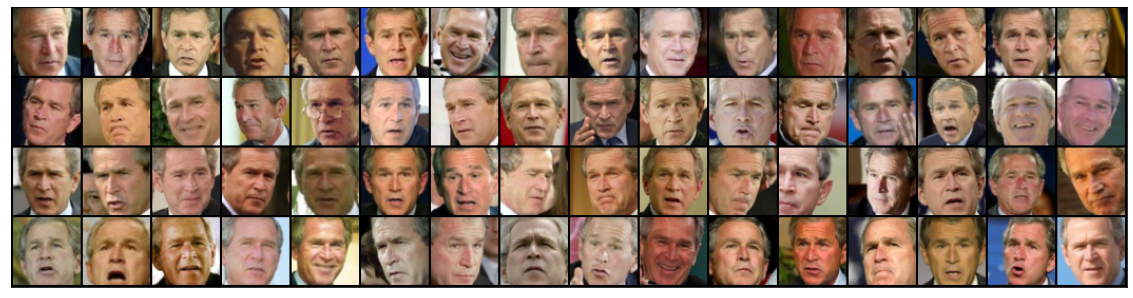

In [13]:
show_batch(train_dl)

In [14]:
class Encoder_Decoder(nn.Module):
  def __init__(self,input_size,hidden_size):
    super().__init__()
    self.encoder = nn.Sequential(
                                nn.Linear(input_size,hidden_size) ,
                                # nn.Sigmoid()
                                nn.ReLU()
                                )
    self.decoder = nn.Sequential(
                                  nn.Linear(hidden_size,input_size)
                                 
                                  # nn.Sigmoid()
                                  )
    
  def forward(self,images):
    # images = images.view(images.size(0), -1)
    out = self.encoder(images)
    return self.decoder(out)

In [15]:
input_size = img_size*img_size*3
hidden_size = 10240

model = Encoder_Decoder(input_size,hidden_size)
to_device(model,device)
model

Encoder_Decoder(
  (encoder): Sequential(
    (0): Linear(in_features=12288, out_features=10240, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10240, out_features=12288, bias=True)
  )
)

In [16]:
for images,_ in train_dl:
  print('Input batch size: ',images.shape)
  print('Input batch flattened: ',images.view(images.size(0), -1).shape)
  # print(images.size(0))
  images = images.view(images.size(0), -1)
  images = to_device(images,device)
  with torch.no_grad():
    output = model(images)
  # recon = output.reshape(output.size(0),-1,img_size,img_size)
  # print('Reconstruted batch size: ',recon.shape)
  # print(output.view(output.size(0),3,250,250).shape)
    loss = F.mse_loss(output,images)
    print('Loss: {:.4f}'.format(loss.item()))
  break

Input batch size:  torch.Size([64, 3, 64, 64])
Input batch flattened:  torch.Size([64, 12288])
Loss: 0.2906


In [17]:
def loss_epoch_end(outputs):
  batch_losses = [x['loss'] for x in outputs]
  epoch_loss = torch.stack(batch_losses).mean()
  return {'epoch_loss' : epoch_loss.item()}
    
def result_epoch_end(epoch,epochs, train_result,valid_result):
  print("Epoch [{}/{}], Train loss: {:.4f}, Valid loss: {:.4f} ".format(epoch+1,epochs, train_result['epoch_loss'],valid_result['epoch_loss']))

In [18]:
def train_model(model,epochs,train_dl,valid_dl,opt):
  history = [] 
  best_model_params = copy.deepcopy(model.state_dict())
  best_loss = 99999.9
  for epoch in range(epochs):
    valid_stats = []
    train_stats = []
    # For training
    for images,_ in train_dl:
      images = images.view(images.size(0), -1)
      images = to_device(images,device)
      output = model(images)
      # recon = output.reshape(output.size(0),-1,img_size,img_size)
      loss = F.mse_loss(output,images)
      opt.zero_grad()
      loss.backward()
      train_stats.append({'loss' : loss})
      opt.step()

    train_result = loss_epoch_end(train_stats)

    #For validation
    for images,_ in valid_dl:
      images = images.view(images.size(0), -1)
      images = to_device(images,device)
      with torch.no_grad():
        output = model(images)
        recon = output.reshape(output.size(0),-1,img_size,img_size)
        loss = F.mse_loss(output,images)
        valid_stats.append({'loss' : loss})
    
    valid_result = loss_epoch_end(valid_stats)


    if best_loss > valid_result['epoch_loss']:
      best_model_params = copy.deepcopy(model.state_dict())
      best_loss = valid_result['epoch_loss']

    if (epoch+1)%1 == 0:
      result_epoch_end(epoch,epochs,train_result,valid_result)
    

    history.append({'tloss':train_result['epoch_loss'],'vloss':valid_result['epoch_loss']})

    if valid_result['epoch_loss'] > train_result['epoch_loss']:
      print('Early Stopping...')
      model.load_state_dict(best_model_params)
      return model, history 


  model.load_state_dict(best_model_params)
  return model, history 


In [19]:
lr = 0.00005
epochs = 20
opt = torch.optim.Adam(model.parameters(), lr)

In [20]:

model,history = train_model(model,epochs,train_dl,valid_dl,opt)

Epoch [1/20], Train loss: 0.1331, Valid loss: 0.0406 
Epoch [2/20], Train loss: 0.0448, Valid loss: 0.0429 
Epoch [3/20], Train loss: 0.0366, Valid loss: 0.0316 
Epoch [4/20], Train loss: 0.0313, Valid loss: 0.0300 
Epoch [5/20], Train loss: 0.0293, Valid loss: 0.0278 
Epoch [6/20], Train loss: 0.0272, Valid loss: 0.0259 
Epoch [7/20], Train loss: 0.0253, Valid loss: 0.0240 
Epoch [8/20], Train loss: 0.0235, Valid loss: 0.0222 
Epoch [9/20], Train loss: 0.0216, Valid loss: 0.0208 
Epoch [10/20], Train loss: 0.0202, Valid loss: 0.0194 
Epoch [11/20], Train loss: 0.0193, Valid loss: 0.0192 
Epoch [12/20], Train loss: 0.0187, Valid loss: 0.0185 
Epoch [13/20], Train loss: 0.0181, Valid loss: 0.0180 
Epoch [14/20], Train loss: 0.0176, Valid loss: 0.0174 
Epoch [15/20], Train loss: 0.0171, Valid loss: 0.0170 
Epoch [16/20], Train loss: 0.0166, Valid loss: 0.0166 
Epoch [17/20], Train loss: 0.0161, Valid loss: 0.0162 
Early Stopping...


In [24]:
thist = [i['tloss'] for i in history]
vhist = [i['vloss'] for i in history]

In [33]:
# print(len(thist)+1)
# print(vhist)

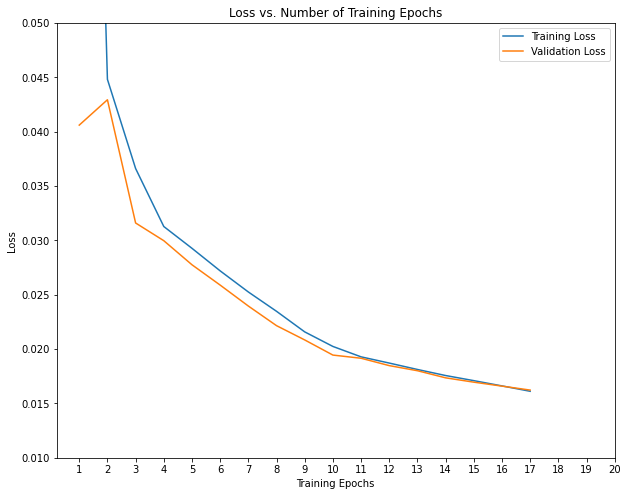

In [32]:
plt.figure(figsize=(10,8))
plt.title('Loss vs. Number of Training Epochs')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.plot(range(1,len(thist)+1),thist,label="Training Loss")
plt.plot(range(1,len(thist)+1),vhist,label="Validation Loss")
plt.ylim((0.01,0.05))
plt.xticks(np.arange(1, epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
# torch.save(model.state_dict(),'encoder_decoder.pth')

In [34]:
def evaluate(model,test_loader):
  recons = []
  #For Testing
  test_stats = []
  for images,_ in test_dl:
    images = images.view(images.size(0), -1)
    images = to_device(images,device)
    with torch.no_grad():
      output = model(images)
      # recon = output.reshape(output.size(0),-1,img_size,img_size)
      loss = F.mse_loss(output,images)
      test_stats.append({'loss' : loss})
      recons.append(output.view(output.size(0),-1,img_size,img_size))

  return recons,loss_epoch_end(test_stats)


In [35]:
img,test_result = evaluate(model,test_dl)

In [46]:
print("Test_loss: {:.2f}%".format(test_result['epoch_loss']*100))

Test_loss: 1.72%


In [ ]:
# torch.max(img[0][1]-img[0][2])

In [40]:
def show_batch1(dl):
    for images in dl:
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images.detach().cpu().clone(), 8).permute(1, 2, 0))
        return images

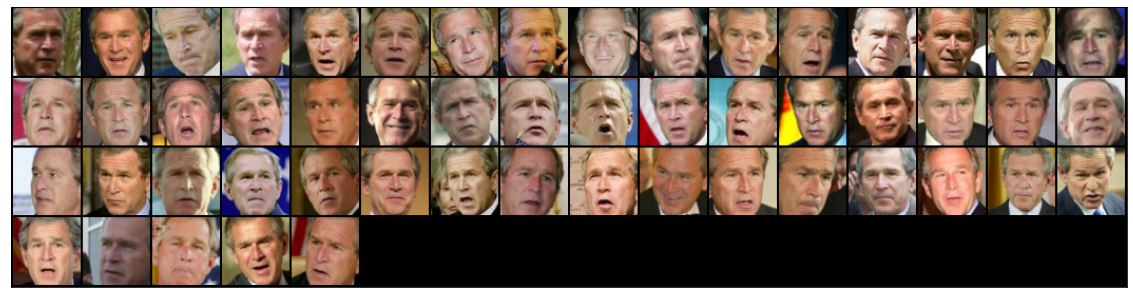

In [38]:
show_batch(test_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


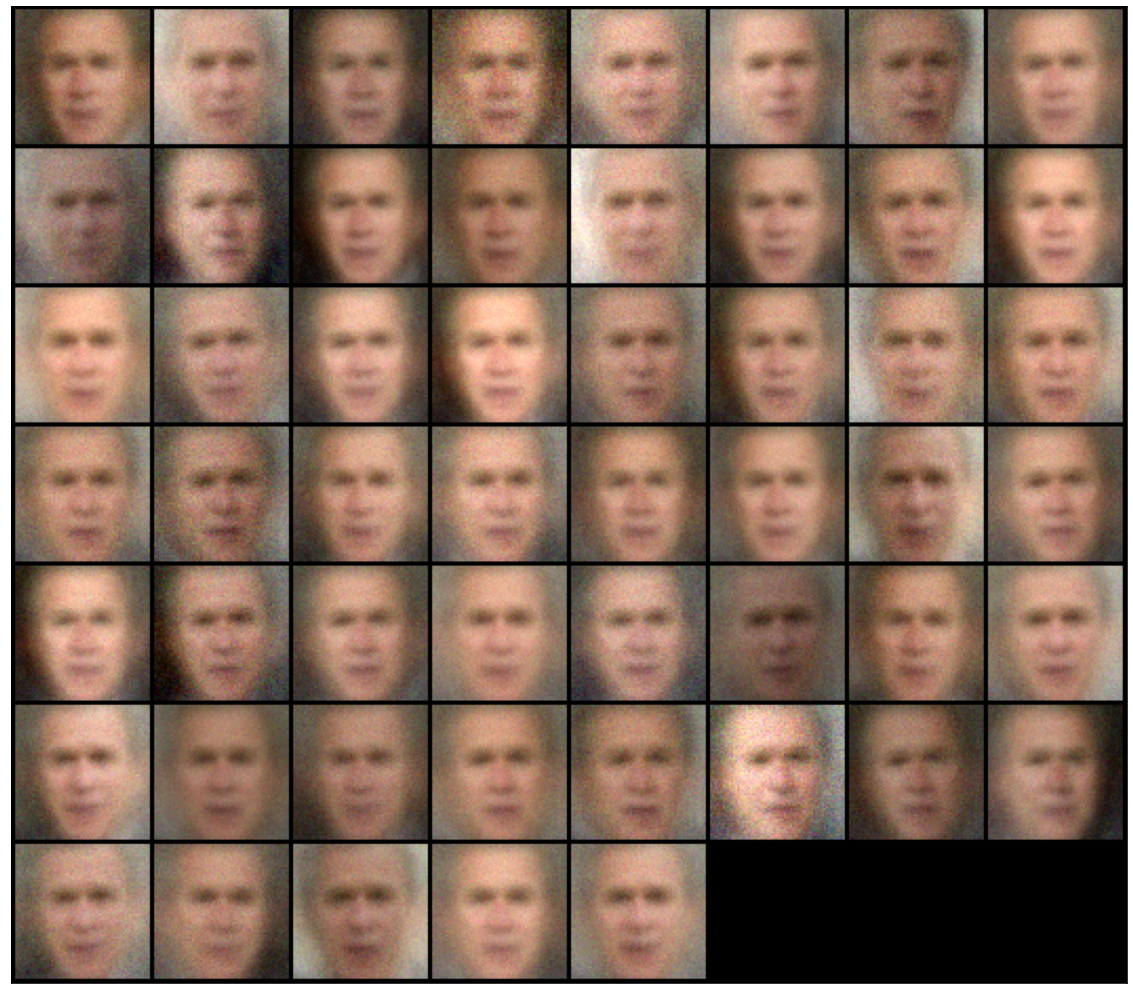

In [41]:
reconstructed_test = show_batch1(img)

In [ ]:
# plt.imshow(original[0][1].detach().cpu().clone().squeeze())

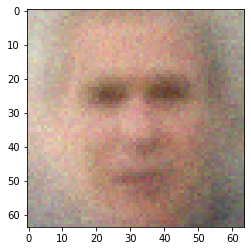

In [42]:
plt.imshow(img[0][1].detach().cpu().clone().squeeze().permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


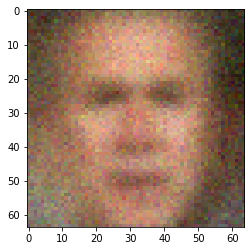

In [43]:
plt.imshow(img[0][3].detach().cpu().clone().squeeze().permute(1, 2, 0))